In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

Missing values in numeric columns:
 Unique ID           0
Indicator ID        0
Geo Join ID         9
Data Value          0
Message         18025
dtype: int64
Numeric data after feature engineering:
    Unique ID  Indicator ID  Geo Join ID  Data Value  Year  Month  \
0     179772           640        409.0         0.3  2015      1   
1     179785           640        209.0         1.2  2015      1   
2     178540           365        209.0         8.6  2011     12   
3     178561           365        409.0         8.0  2011     12   
4     823217           365        409.0         6.1  2022      6   

   Geo Join Ratio  
0        0.000692  
1        0.000354  
2        0.000354  
3        0.000692  
4        0.000692  
Number of features: 7


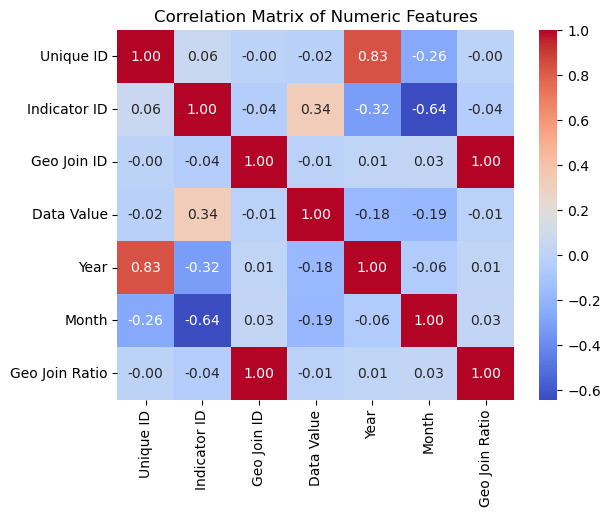

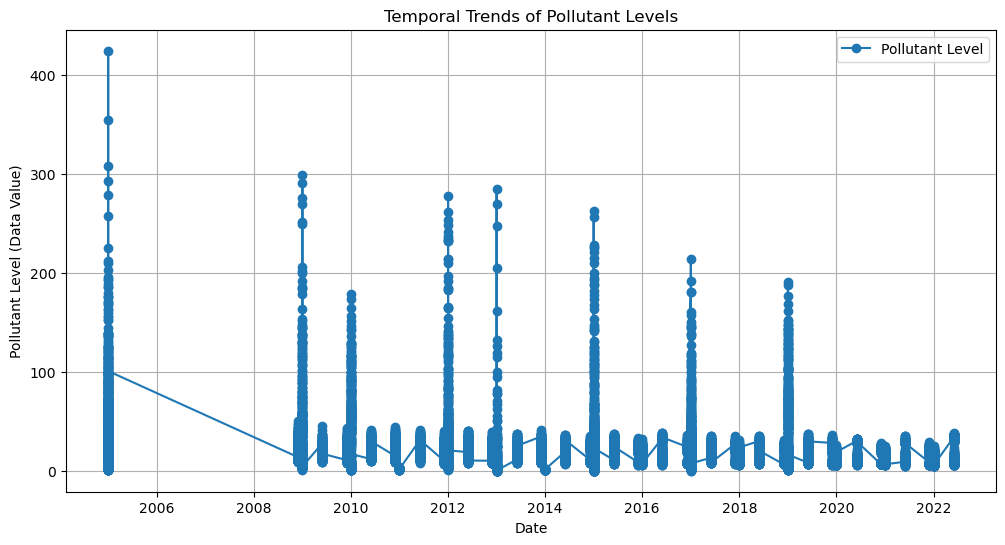

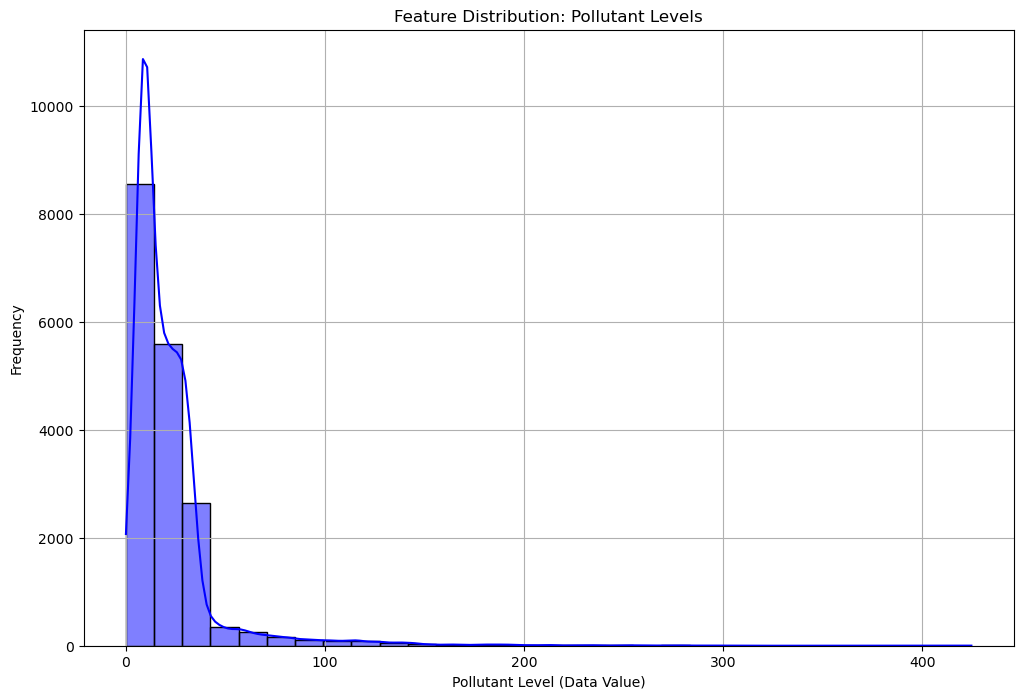

In [31]:
# Load the dataset
data = pd.read_csv("Air_Quality.csv")

# Select only numeric columns
numeric_data = data.select_dtypes(include=[np.number])

# Check for missing values in numeric columns
print("Missing values in numeric columns:\n", numeric_data.isnull().sum())

# Fill missing values in numeric columns with the mean
numeric_data = numeric_data.fillna(numeric_data.mean())

# Drop columns with no variance (constant columns)
numeric_data = numeric_data.loc[:, numeric_data.var() > 0]

# Feature engineering: Adding new features
data['Year'] = pd.to_datetime(data['Start_Date']).dt.year  # Extract year from Start_Date
data['Month'] = pd.to_datetime(data['Start_Date']).dt.month  # Extract month from Start_Date
data['Geo Join Ratio'] = data['Geo Join ID'] / (data['Geo Join ID'].mean() + 1)  # Example ratio feature

# Merge new features into numeric_data
numeric_data['Year'] = data['Year']
numeric_data['Month'] = data['Month']
numeric_data['Geo Join Ratio'] = data['Geo Join Ratio']

# Ensure at least 5 features
print("Numeric data after feature engineering:\n", numeric_data.head())
print("Number of features:", numeric_data.shape[1])

# Compute and visualize the correlation matrix
sns.heatmap(numeric_data.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Numeric Features")
plt.show()

# Temporal Trends
data['Start_Date'] = pd.to_datetime(data['Start_Date'])
time_series_data = data.sort_values('Start_Date')

plt.figure(figsize=(12, 6))
plt.plot(time_series_data['Start_Date'], time_series_data['Data Value'], marker='o', label="Pollutant Level")
plt.title("Temporal Trends of Pollutant Levels")
plt.xlabel("Date")
plt.ylabel("Pollutant Level (Data Value)")
plt.legend()
plt.grid(True)
plt.show()

# Feature Distribution
plt.figure(figsize=(12, 8))
sns.histplot(data['Data Value'], kde=True, bins=30, color="blue")
plt.title("Feature Distribution: Pollutant Levels")
plt.xlabel("Pollutant Level (Data Value)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [3]:
# Check if the target column exists
target_column = "Data Value"  # Replace with the actual target column name
if target_column not in numeric_data.columns:
    raise KeyError(f"Target column '{target_column}' not found in the dataset.")

# Separate features and target
features = numeric_data.drop(columns=[target_column])
target = numeric_data[target_column]

# Handle missing values
features = features.fillna(features.mean())

# Verify no NaNs remain
if features.isnull().any().any():
    raise ValueError("NaN values remain in features after imputation.")

# Normalize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(scaled_features, target, test_size=0.2, random_state=42)


Random Forest Regressor (Default Parameters)
R2 Score: 0.9200002166909415
MSE: 43.46022417142857
MAE: 2.425469625520111


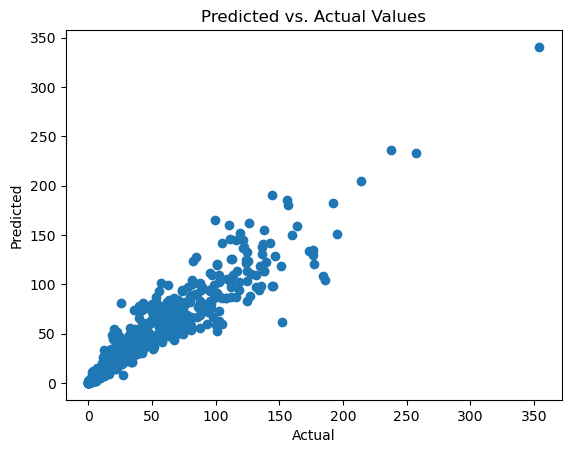

In [44]:
# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("\nRandom Forest Regressor (Default Parameters)")
print("R2 Score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))

# Plot predictions vs. actual values
plt.scatter(y_test, y_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs. Actual Values")
plt.show()

In [5]:
"The computation below takes a little bit as it is parsing through quite a bit of data."

'The computation below takes a little bit as it is parsing through quite a bit of data.'

In [6]:
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print("\nBest Hyperparameters:", best_params)

# Train the model with best parameters
rf_best = RandomForestRegressor(**best_params, random_state=42)
rf_best.fit(X_train, y_train)

# Predict on the test set with the best model
y_pred_best = rf_best.predict(X_test)

# Evaluate the optimized model
print("\nRandom Forest Regressor (Best Parameters)")
print("R2 Score:", r2_score(y_test, y_pred_best))
print("MSE:", mean_squared_error(y_test, y_pred_best))


Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

Random Forest Regressor (Best Parameters)
R2 Score: 0.9190811601723111
MSE: 43.959505552874056


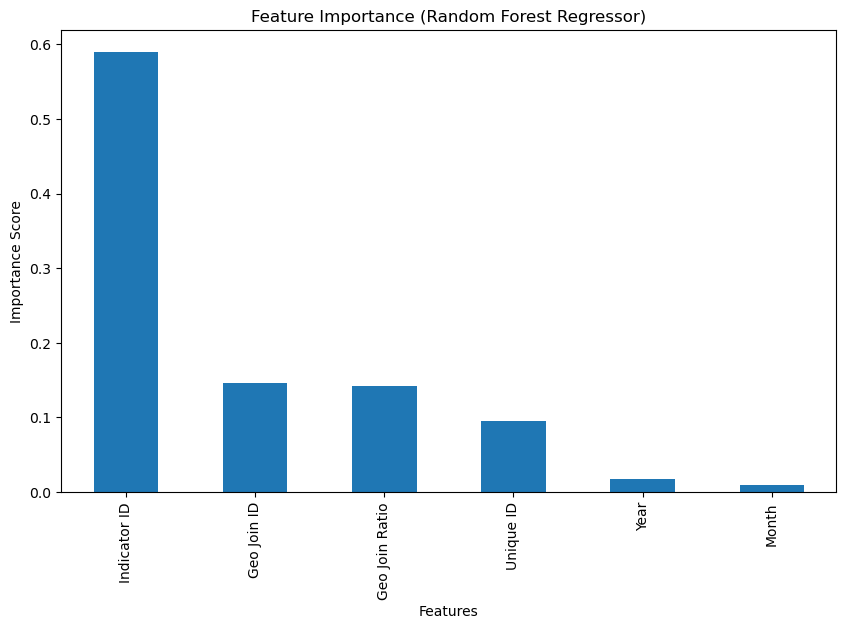


Feature Importance:
Indicator ID      0.589735
Geo Join ID       0.145661
Geo Join Ratio    0.141638
Unique ID         0.095060
Year              0.017946
Month             0.009960
dtype: float64


In [7]:
# Get feature importance
feature_importance = pd.Series(rf_best.feature_importances_, index=features.columns)

# Sort and plot feature importance
feature_importance.sort_values(ascending=False).plot(kind='bar', figsize=(10, 6))
plt.title("Feature Importance (Random Forest Regressor)")
plt.ylabel("Importance Score")
plt.xlabel("Features")
plt.show()

print("\nFeature Importance:")
print(feature_importance.sort_values(ascending=False))